# Food Classification with PyTorch (torchvision)
Here, I will work on a project that is based on classifying up to 101 foods based on the Food-101 dataset found              here -> https://www.kaggle.com/datasets/dansbecker/food-101. 

In [1]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import torch
from   torch             import nn
import matplotlib.pyplot as plt
import zipfile
from   pathlib           import Path
import os
import random
from   PIL              import Image
import numpy            as np
from   torchvision      import transforms
from   torchvision      import datasets
import random
from   PIL               import Image
from   torch.utils.data  import DataLoader
from   torch.optim       import optimizer
from   timeit            import default_timer as timer

torch.__version__

'2.0.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Mon Sep 11 19:20:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
| 35%   44C    P5              30W / 170W |    536MiB / 12288MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#  Getting the data and loading it properly


In [4]:
#"C:\Users\ferna\Jupyter_Files\Food-Classification\Data\food-101.zip"
# the zip file of the data where our data is in
data_path = Path("Data/")
DATA_PATH_ZIP = data_path / "food-101.zip"
DATA_PATH = data_path / "food-101"

# Check if the file is already there-> if it is no need to download anything-> if it isn't -> see if the zip file is there
# -> if it isn't please look at the link given to download the data. The zipfile is rather large!



if DATA_PATH.is_dir():
    print(f"{DATA_PATH} directory is there. No need to download")
    
else:
    print(f"{DATA_PATH} was not found -> download from {DATA_PATH_ZIP}...")
    DATA_PATH.mkdir(parents=True, exist_ok=True)
    try:
        with zipfile.ZipFile(DATA_PATH_ZIP, "r") as zip_ref:
            print(f"Unzipping {DATA_PATH_ZIP}")
            zip_ref.extractall(DATA_PATH)
    except:
        print(f"Failure in the unzipping process! see if {DATA_PATH_ZIP} or {DATA_PATH} are set appropiately")
        print("If they are...see if you have the zip file->look at the README for information regarding the data!")

    

Data\food-101 directory is there. No need to download


In [5]:
# Go through the directories that are accessible to us
FOOD_DATA_PATH = DATA_PATH / "images"

def walk_thru_dir(dir_path):
  """ Walks through dir_path returing its contents...."""
  print(f"The path given was {dir_path}")

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} in {dirpath}.")

# If you want to see the directory paths that are within range of the path given
# walk_thru_dir(FOOD_DATA_PATH)

## Load the data into train/test folders with all 101 foods split 75/25

In [6]:
# run the command if you do not have the split-folders library
# It will add to your directory a train/test split datafolder so do not run this again by accident! only do it once
# Make sure your directories are set correctly
# Comment out the code for complete safety if you already have the files 


# !pip3 install split-folders
run_again = False
input_dir = "Data/food-101/images"
output_dir = "Data/food-101/images-split"

if run_again:
    import splitfolders
    if Path(output_dir).is_dir():
        print(f"split folder {output_dir} was found...will not perform any splitting train/test")
    else:
        # splits the data 75/25-> can be changed! make sure that the output_dir isn't there!
        splitfolders.ratio(input_dir, output=output_dir, seed=2, ratio=(0.75, 0.25))
else:
    print(f"run_again set to {run_again}. Will not run the code to split the folders appropiately...")


run_again set to False. Will not run the code to split the folders appropiately...


In [8]:
# walk_thru_dir(output_dir)

In [7]:
# Load all the images from the path output_dir=Data/food-101/images-split and get a list of all images in it
output_dir = Path(output_dir)
image_path_list = list(output_dir.glob("*/*/*.jpg"))

random image path: Data\food-101\images-split\train\nachos\3274926.jpg
Image class nachos
height: 384
width: 512


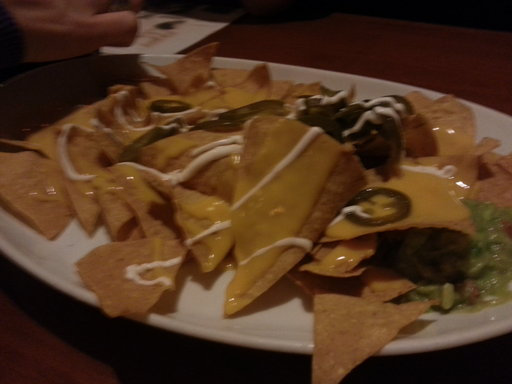

In [8]:
# look at a random image and get its class
rdm_image = random.choice(image_path_list)
image_class = rdm_image.parent.stem
image = Image.open(rdm_image)

# Some data regarding the image and the image
print(f"random image path: {rdm_image}")
print(f"Image class {image_class}")
print(f"height: {image.height}")
print(f"width: {image.width}")
image

## Analyzing the data to see its information regarding the images such as height/width

In [9]:
# Takes a while to run (this is to do some data analyzing before turning to tensors to see an optimal size of transformation)
# Ran some data analysis in the next cell
run = False
if run:
    image_np = np.asarray(image)
    image_np.shape

    # To get some information regarding our data -> Turned into np arrays into a list
    def img_to_np(image): 
        return np.asarray(Image.open(image))

    np_list = list(map(img_to_np, image_path_list))
else:
    print(f"Run status set to {run}")

Run status set to False


In [10]:
# We have over 101,000 datapoints for reference. They are in datatype uint8 0-255 so we might have to normalize it when it gets
# transformed into a tensor
width = 0
height = 0
#(H, W, C)
lowest_h = 500
lowest_w = 600
highest_h = 0
highest_w = 0

if run:
    for x in np_list:
        height += x.shape[0]
        width += x.shape[1]
        lowest_h = min(lowest_h, x.shape[0])
        lowest_w = min(lowest_w, x.shape[1])
        highest_h = max(highest_h, x.shape[0])
        highest_w = max(highest_w, x.shape[1])


    average_h = float(height) / len(np_list)
    average_w = float(width) / len(np_list)

    print(f"Average height: {average_h:4f}\n Average width: {average_w:4f}")
    print(f"Lowest height: {lowest_h}\n Lowest width: {lowest_w}")
    print(f"Highest height: {highest_h}\n Highest width: {highest_w}")
else:
    print(f"Run status set to {run} from previous cell")

Run status set to False from previous cell


# Transforming data into tensors, proper datasets and DataLoaders with data augmentation

### The transform that will be applied to each image (train/test)

In [11]:
# First Ver. resize size=(155,155)


# The transformation that our training data will go through
train_transform = transforms.Compose([
    transforms.Resize(size=(180,180)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
# test transformation (change the size and to tensor only)
test_transform = transforms.Compose([
    transforms.Resize(size=(180,180)),
    transforms.ToTensor()
])

In [12]:
# Setting up the directory path for train and test
train_dir = output_dir / "train"
test_dir = output_dir / "val"


print(f"train directory: |{train_dir}|\ntest directory:  |{test_dir}|")

train directory: |Data\food-101\images-split\train|
test directory:  |Data\food-101\images-split\val|


In [13]:
train_data_augment = datasets.ImageFolder(root=train_dir, 
                                          transform=train_transform, 
                                          target_transform=None)
test_data_augment =  datasets.ImageFolder(root=test_dir,  
                                          transform=test_transform)

In [14]:
# Turn Datasets into DataLoaders

BATCH_SIZE = 20
NUM_WORKERS = max(1, os.cpu_count() - 4) # I have 12, though in the occasion it goes lower than 0 -> max 1 (can be changed)

torch.manual_seed(42)

train_dataloader = DataLoader(dataset=train_data_augment,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data_augment,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS)

In [15]:
# class names in list alongside a dictionary
class_names = train_data_augment.classes
class_dict = train_data_augment.class_to_idx
len(class_names)

101

In [16]:
# !pip3 install import-ipynb
# if needed run the command above to use the following cell. Otherwise, if you do not have the module then it
# will not be able to import functions from `model.ipynb` 
%run model.ipynb
# This is to see if a function is able to be called successfully from `model.ipynb`
rdm()

You were able to access a function within `model.ipynb`


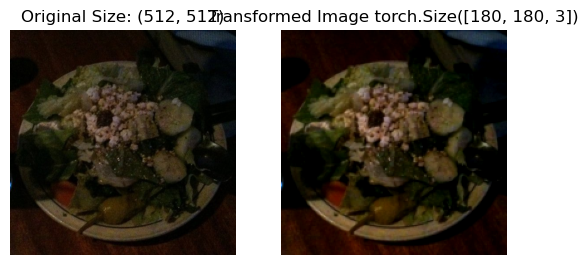

In [28]:
# Look how the transformed image looks
transformed_image(image_path_list, train_transform)

## Model preparation and debugging
Here we create a model to debug and determine certain parameters as needed. Needed to debug to see what was the appropiate scalar to multiply the hidden units to the scale of the matrix generated by the previous sequential blocks. 

In [29]:
torch.manual_seed(42)
de_model = Food_Model(input_shape=3,
                      hidden_units=100,
                      output_shape = len(class_names)).to(device)

de_model

Food_Model(
  (block_1): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU6()
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU6()
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=176400, out_features=101, bias=True)
  )
)

In [ ]:
# Attempt to give the model a batch (debugging purposes to figure out the needed input
#  for nn.Linear for in_features)

image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

In [ ]:
de_model(image_batch.to(device))

# Train and Evaluate the Model

## ==========================================================

In [20]:
%run model.ipynb
train = False
seed = 2
NUM_EPOCHS = 15
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

if seed != None:
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
else:
    print(f"No seed will be used for the training process")
    
if train:
    # Model instance
    model = Food_Model(input_shape=3,
                       hidden_units=100,
                       output_shape = len(class_names)).to(device)


    # Loss function and optimizer for our model
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), 
                                lr=1e-3)

    # set a timer to calclulate the time
    start_time = timer()

    # Train
    model_res = train(model=model, 
                      train_dataloader=train_dataloader, 
                      test_dataloader=test_dataloader, 
                      optimizer=optimizer, 
                      loss_fn=loss_fn, 
                      epochs=NUM_EPOCHS, 
                      device=device)

    #the end time
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")
else:
    print(f"train ")

SyntaxError: incomplete input (385740254.py, line 41)